# 7.8 遥感图像场景分类可视化解释

## 7.8.1 场景分类训练过程

本节为遥感图像场景分类可视化。

示例任务为airplane、storagetanks及tenniscourt三个场景的分类任务。

场景分类训练过程示例代码[点此下载](https://github.com/huyij1013/Tensorflow-Resnet-Image-Classification)

## 7.8.2 分类过程可视化

### 加载可视化所需模块：

In [1]:
# Boilerplate imports.
import tensorflow.compat.v1 as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import pickle
import os
import tf_slim as slim
import inception_v3
import saliency
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import config as cfg
import resnet
import cv2 as cv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 定义可视化所需函数：

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    # im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):
    if ax is None:
        fig, ax = P.subplots()
    else:
        fig = ax.figure

    P.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im / 127.5 - 1.0

### 加载训练好的场景分类模型：

In [3]:
graph = tf.Graph()

with graph.as_default():


    input_img = tf.placeholder(tf.float32,[None, cfg.image_height, cfg.image_width, 3])
    cls_score = resnet.resnet_base(input_img, scope_name=cfg.NET_NAME, is_training=False)
    init = tf.global_variables_initializer()
    output_dir = r'F:\learning\interpretation\Tensorflow-Resnet-Image-Classification-master\output_2'
    ckpt_file = tf.train.latest_checkpoint(output_dir)
    neuron_selector = tf.placeholder(tf.int32)
    y = cls_score[0][neuron_selector]
    prediction = tf.argmax(cls_score, 1)

    # with tf.Session(graph=graph) as sess:

    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_file)

    variables = tf.global_variables()
    saver = tf.train.Saver(variables)
    init = tf.global_variables_initializer()

    sess.run(init)
    saver.restore(sess, ckpt_file)



Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from F:\learning\interpretation\Tensorflow-Resnet-Image-Classification-master\output_2\output.model-2500
INFO:tensorflow:Restoring parameters from F:\learning\interpretation\Tensorflow-Resnet-Image-Classification-master\output_2\output.model-2500


### 使用加载的模型进行预测：

In [4]:
imagepath = r'F:\learning\interpretation\Tensorflow-Resnet-Image-Classification-master\UCMerced_LandUse\1\train\airplane\airplane35.tif'
test_image_single_1 = cv.imdecode(np.fromfile(imagepath, dtype=np.uint8), 1)
test_image_single = cv.resize(test_image_single_1, (cfg.image_height, cfg.image_width))
test_image_single = np.reshape(test_image_single, [1, cfg.image_height, cfg.image_width, 3])
im = np.reshape(test_image_single_1, [cfg.image_height, cfg.image_width, 3])
test_image_single.astype(np.float32)
cls_score_1 = sess.run(cls_score, feed_dict={input_img: test_image_single})

### 分类过程可视化方法:

示例一：

Vanilla Gradients([参考文献](https://arxiv.org/abs/1312.6034)),([参考文献](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22))

SmoothGrad([参考文献](https://arxiv.org/abs/1706.03825))

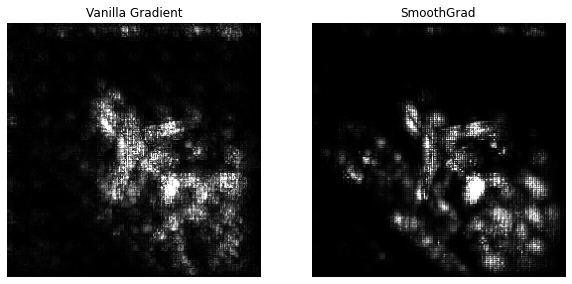

In [5]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, input_img)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(test_image_single[0], feed_dict = {neuron_selector: 1})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(test_image_single[0], feed_dict = {neuron_selector: 1})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

示例二：

Guided Backpropogation（[参考文献](https://arxiv.org/abs/1412.6806)）

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


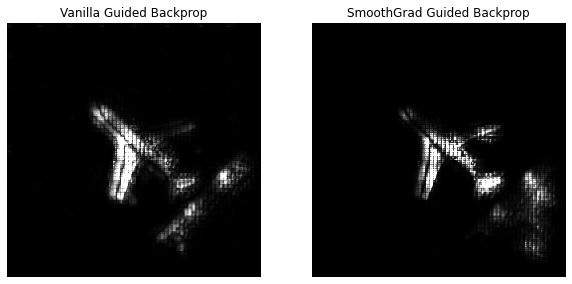

In [6]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = saliency.GuidedBackprop(graph, sess, y, input_img)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(test_image_single[0], feed_dict = {neuron_selector: 1})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(test_image_single[0], feed_dict = {neuron_selector: 1})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

示例三：

XRAI（[参考文献](https://arxiv.org/abs/1906.02825)）

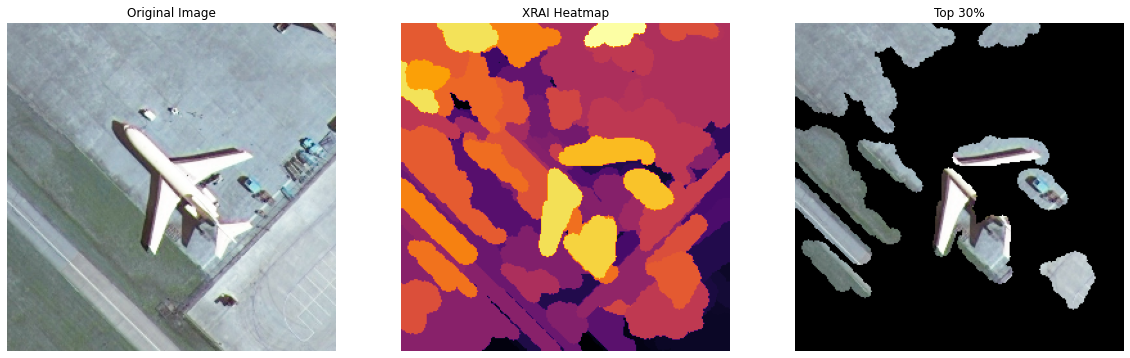

In [7]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, input_img)

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(test_image_single[0], feed_dict={neuron_selector: 1})

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

示例四：

Integrated Gradients（[参考文献](https://arxiv.org/abs/1703.01365)）

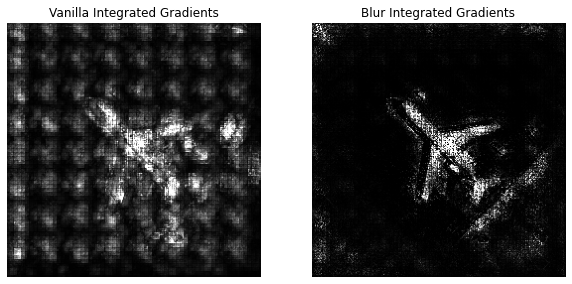

In [8]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, input_img)
blur_ig = saliency.BlurIG(graph, sess, y, input_img)

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(test_image_single[0].shape)
baseline.fill(-1)

# Compute the vanilla mask and the Blur IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  test_image_single[0], feed_dict = {neuron_selector: 1}, x_steps=25, x_baseline=baseline)
blur_ig_mask_3d = blur_ig.GetMask(
  test_image_single[0], feed_dict = {neuron_selector: 1})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))


### 更多详细代码请见[链接](https://github.com/huyij1013/history-of-interpretation)